# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import library

In [2]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

# Skenario 1 : data tanpa clahe tanpa oversampling

## Membaca data

In [3]:
CLASS_NAMES = ['Benign', 'Early', 'Pre', 'Pro']

def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(CLASS_NAMES):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = tf.convert_to_tensor(images, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.uint8)

    return (images, labels)

In [ ]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/train


100%|██████████| 643/643 [00:18<00:00, 33.99it/s] 


Loading /content/drive/MyDrive/SKRIPSI/dataset/original/val


100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


Loading /content/drive/MyDrive/SKRIPSI/dataset/original/test


100%|██████████| 81/81 [01:08<00:00,  1.18it/s]


## Sampel data

In [4]:
def show_sample_images(data, n_images):

    images, labels = data

    fig, axs = plt.subplots(nrows=n_images, ncols=len(CLASS_NAMES), figsize=(9, 6),
                            subplot_kw={'xticks': [], 'yticks': []})

    for col in range(len(CLASS_NAMES)):
        sample = images[labels==col][:n_images]
        for row in range(n_images):
            axs[row][col].imshow(sample[row])
            axs[row][col].set_title(CLASS_NAMES[col])

    plt.tight_layout()
    plt.show()

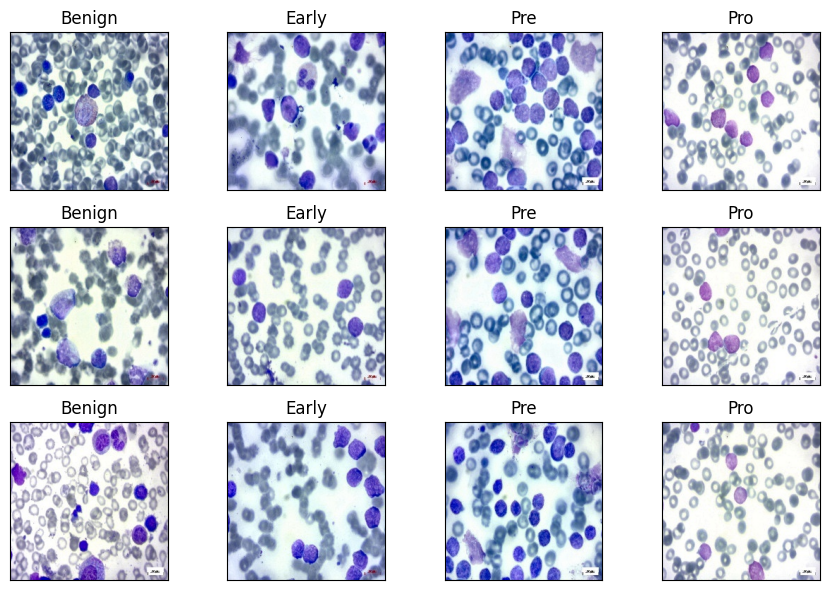

In [ ]:
show_sample_images(data=(X_train, y_train), n_images=3)

## Distribusi data masing-masing kelas

In [5]:
def plot_distribution_data(train_data, val_data, test_data):
    amount = {
        'Train': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Val': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Test': [ 0 for _ in range(len(np.unique(train_data))) ],
    }

    # count amount of data train
    for clas in train_data:
        amount['Train'][clas] += 1

    # count amount of data val
    for clas in val_data:
        amount['Val'][clas] += 1

    # count amount of data test
    for clas in test_data:
        amount['Test'][clas] += 1

    x = np.arange(len(CLASS_NAMES))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in amount.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total')
    ax.set_title('Data distribution by classes')
    ax.set_xticks(x + width, CLASS_NAMES)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1000)

    plt.show()

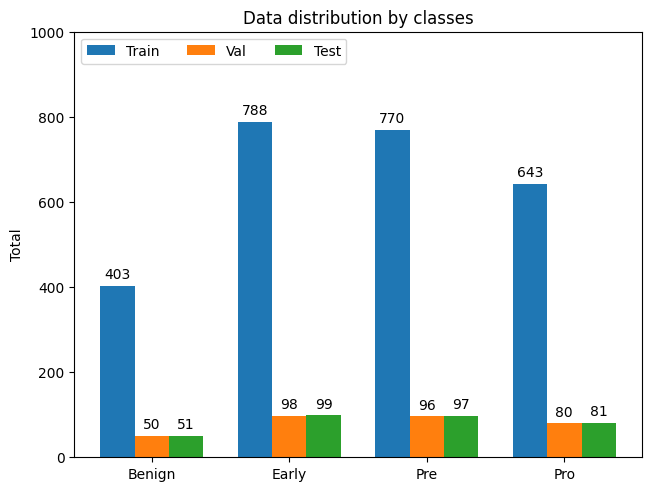

In [ ]:
plot_distribution_data(y_train, y_val, y_test)

## Membuat model

In [6]:
class Inception(keras.Model):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
        super(Inception, self).__init__()

        self.path_1 = layers.Conv2D(filters_1x1, kernel_size=(1, 1), padding='same', activation='relu')
        self.path_2 = Sequential([
            layers.Conv2D(filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')
        ])
        self.path_3 = Sequential([
            layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')
        ])
        self.path_4 = Sequential([
            layers.MaxPool2D((3, 3), strides=(1, 1), padding='same'),
            layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')
        ])

    def call(self, x):
        path1 = self.path_1(x)
        path2 = self.path_2(x)
        path3 = self.path_3(x)
        path4 = self.path_4(x)
        return layers.concatenate(inputs=[path1, path2, path3, path4], axis=3)

class Googlenet(keras.Model):
    def __init__(self):
        super(Googlenet, self).__init__()

        self.sequential_1 = Sequential([
            layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            layers.Conv2D(64, 1, strides=1, padding='same', activation='relu'),
            layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                      filters_5x5_reduce=16, filters_5x5=32, filters_pool=32),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                      filters_5x5_reduce=32, filters_5x5=96, filters_pool=64),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                      filters_5x5_reduce=16, filters_5x5=48, filters_pool=64),
        ])
        self.aux_1 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax'),
        ])
        self.sequential_2 = Sequential([
            Inception(filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
        ])
        self.aux_2 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax')
        ])
        self.sequential_3 = Sequential([
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            Inception(filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.4),
            layers.Dense(4, activation='softmax')
        ])
    def call(self, x):

        x = self.sequential_1(x)
        aux_1   = self.aux_1(x)
        x = self.sequential_2(x)
        aux_2   = self.aux_2(x)
        x = self.sequential_3(x)
        return {'result':x, 'aux_1':aux_1, 'aux_2':aux_2}

In [ ]:
model = Googlenet()

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='original_imbalance.weights.h5',
    monitor='val_result_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(
    X_train, [y_train, y_train, y_train],
    validation_data=(X_val, [y_val, y_val, y_val]),
    batch_size=32,
    epochs=40,
    callbacks=[cp_callback]
)

Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - aux_1_accuracy: 0.3182 - aux_1_loss: 1.3594 - aux_2_accuracy: 0.3026 - aux_2_loss: 0.4091 - loss: 2.1777 - result_accuracy: 0.2924 - result_loss: 0.4092
Epoch 1: val_result_accuracy improved from -inf to 0.30247, saving model to original_imbalance.weights.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 92s 599ms/step - aux_1_accuracy: 0.3180 - aux_1_loss: 1.3593 - aux_2_accuracy: 0.3026 - aux_2_loss: 0.4091 - loss: 2.1776 - result_accuracy: 0.2925 - result_loss: 0.4092 - val_aux_1_accuracy: 0.5031 - val_aux_1_loss: 1.2645 - val_aux_2_accuracy: 0.3025 - val_aux_2_loss: 0.4062 - val_loss: 2.0915 - val_result_accuracy: 0.3025 - val_result_loss: 0.4065
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - aux_1_accuracy: 0.3667 - aux_1_loss: 1.3588 - aux_2_accuracy: 0.2974 - aux_2_loss: 0.4073 - loss: 2.1739 - result_accuracy: 0.2838 - result_loss: 0.4079
Epoch 2: val_result_accuracy did not improve from 0.30247
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step 

## plot history accuracy dan loss

In [7]:
def plot_history(loss, val_loss, acc, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])

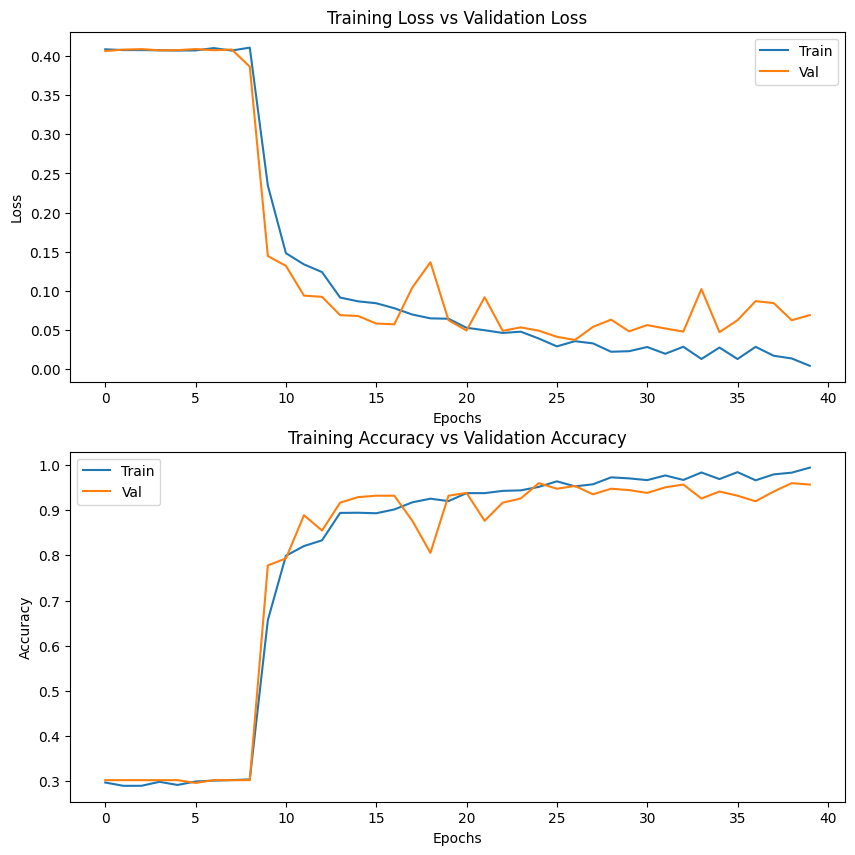

In [ ]:
plot_history(
    history.history['result_loss'],
    history.history['val_result_loss'],
    history.history['result_accuracy'],
    history.history['val_result_accuracy']
)

## Evaluasi model

In [8]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step


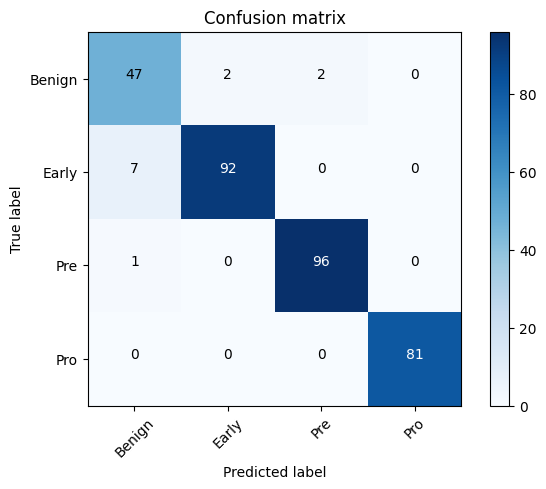

In [ ]:
# predict data test
model.load_weights('original_imbalance.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred.numpy(), target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Benign       0.85      0.92      0.89        51
       Early       0.98      0.93      0.95        99
         Pre       0.98      0.99      0.98        97
         Pro       1.00      1.00      1.00        81

    accuracy                           0.96       328
   macro avg       0.95      0.96      0.96       328
weighted avg       0.96      0.96      0.96       328



In [ ]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet", exist_ok=True)
tf.saved_model.save(model, '/content/drive/MyDrive/SKRIPSI/googlenet/original_imbalanced_model')

# Skenario 2 : data tanpa clahe dengan oversampling Deep SMOTE

## Membaca data

In [ ]:
X_generated, y_generated = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/generated")

X_generated = X_generated / 255

# menggabungkan dengand data train asli
X_train = tf.concat([X_train, X_generated], axis=0)
y_train = tf.concat([y_train, y_generated], axis=0)

data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle dataset
shuffled_data = data.shuffle(buffer_size=len(X_train))
X_train, y_train = zip(*shuffled_data)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.uint8)

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/generated


100%|██████████| 385/385 [00:02<00:00, 178.42it/s]
0it [00:00, ?it/s]
100%|██████████| 145/145 [00:04<00:00, 31.57it/s] 


## Sampel data

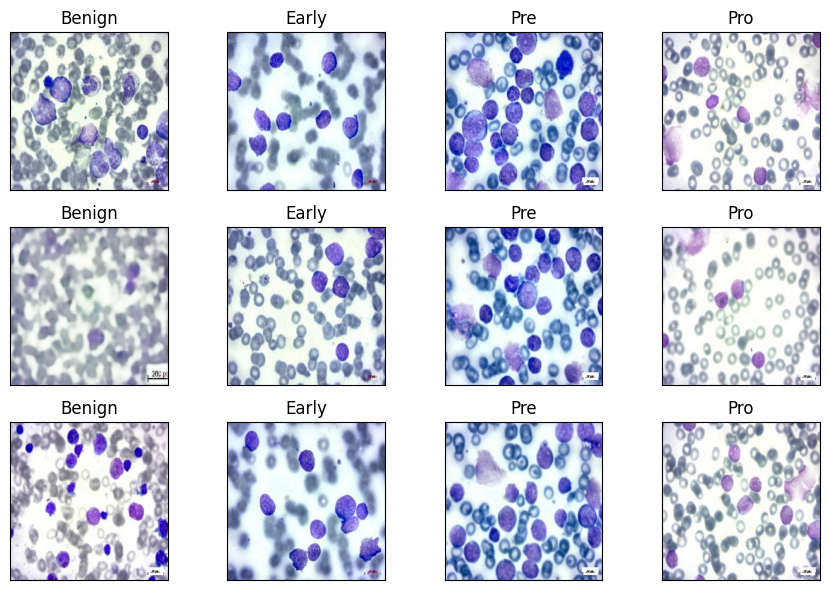

In [ ]:
show_sample_images(data=(X_train, y_train), n_images=3)

## Distribusi data masing-masing kelas

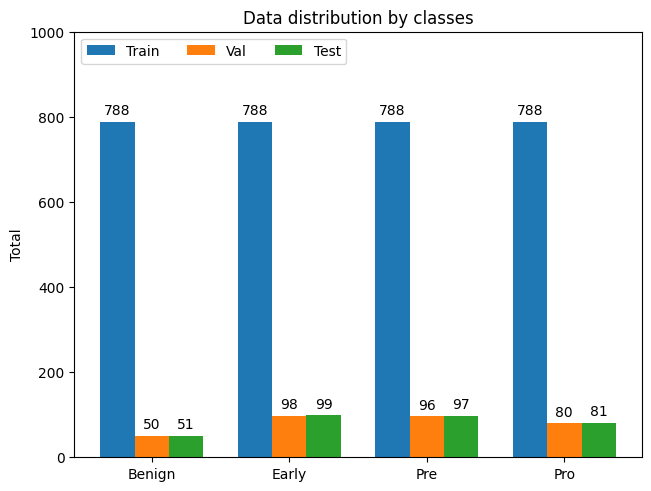

In [ ]:
plot_distribution_data(y_train, y_val, y_test)

## Membuat model

In [ ]:
model = Googlenet()

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='original_balance.weights.h5',
    monitor='val_result_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(
    X_train, [y_train, y_train, y_train],
    validation_data=(X_val, [y_val, y_val, y_val]),
    batch_size=32,
    epochs=40,
    callbacks=[cp_callback]
)

Epoch 1/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - aux_1_accuracy: 0.3282 - aux_1_loss: 1.3549 - aux_2_accuracy: 0.2889 - aux_2_loss: 0.4172 - loss: 2.2189 - result_accuracy: 0.2904 - result_loss: 0.4468
Epoch 1: val_result_accuracy improved from -inf to 0.70370, saving model to original_balance.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 402ms/step - aux_1_accuracy: 0.3297 - aux_1_loss: 1.3526 - aux_2_accuracy: 0.2902 - aux_2_loss: 0.4165 - loss: 2.2151 - result_accuracy: 0.2916 - result_loss: 0.4459 - val_aux_1_accuracy: 0.7284 - val_aux_1_loss: 0.7041 - val_aux_2_accuracy: 0.7037 - val_aux_2_loss: 0.2453 - val_loss: 1.2177 - val_result_accuracy: 0.7037 - val_result_loss: 0.2425
Epoch 2/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - aux_1_accuracy: 0.7219 - aux_1_loss: 0.6867 - aux_2_accuracy: 0.7068 - aux_2_loss: 0.2158 - loss: 1.1227 - result_accuracy: 0.6921 - result_loss: 0.2201
Epoch 2: val_result_accuracy did not improve from 0.70370
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - 

## plot history accuracy dan loss

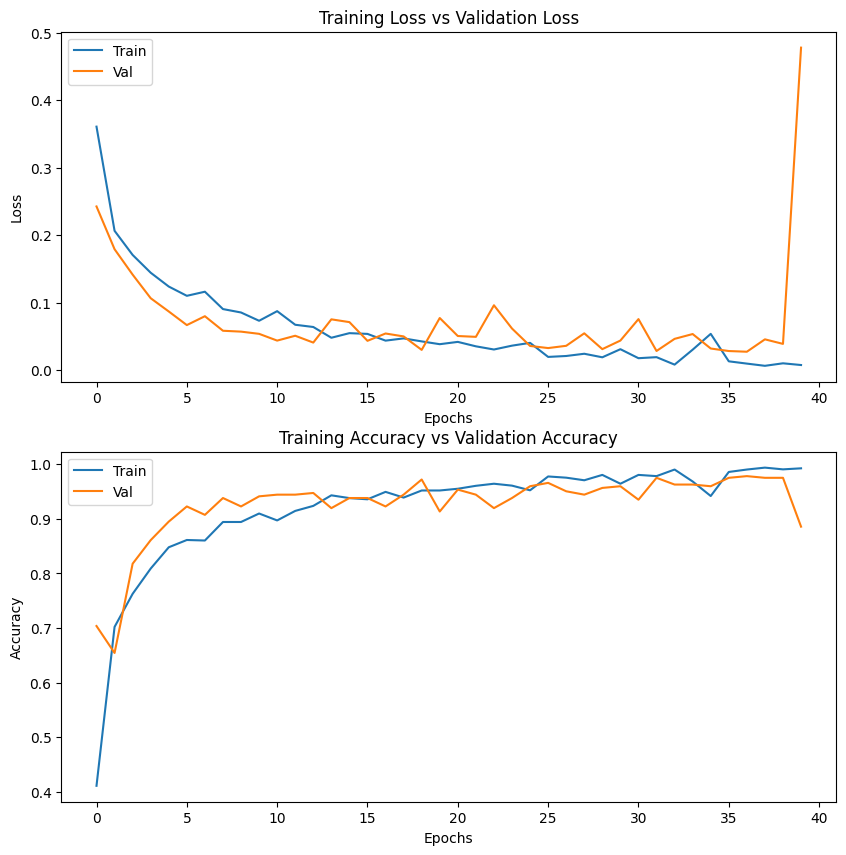

In [ ]:
plot_history(
    history.history['result_loss'],
    history.history['val_result_loss'],
    history.history['result_accuracy'],
    history.history['val_result_accuracy']
)

## Evaluasi model

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step


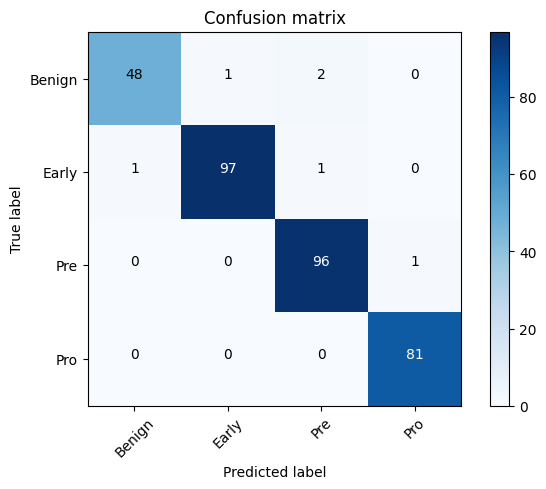

In [ ]:
# predict data test
model.load_weights('original_balance.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred.numpy(), target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Benign       0.98      0.94      0.96        51
       Early       0.99      0.98      0.98        99
         Pre       0.97      0.99      0.98        97
         Pro       0.99      1.00      0.99        81

    accuracy                           0.98       328
   macro avg       0.98      0.98      0.98       328
weighted avg       0.98      0.98      0.98       328



In [ ]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet", exist_ok=True)
tf.saved_model.save(model, '/content/drive/MyDrive/SKRIPSI/googlenet/original_balanced_model')

# Skenario 3 : data clahe tanpa oversampling

## Membaca data

In [9]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/train


100%|██████████| 643/643 [00:11<00:00, 54.76it/s] 


Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/val


100%|██████████| 80/80 [00:29<00:00,  2.72it/s]


Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/test


100%|██████████| 81/81 [00:31<00:00,  2.58it/s]


## Sampel data

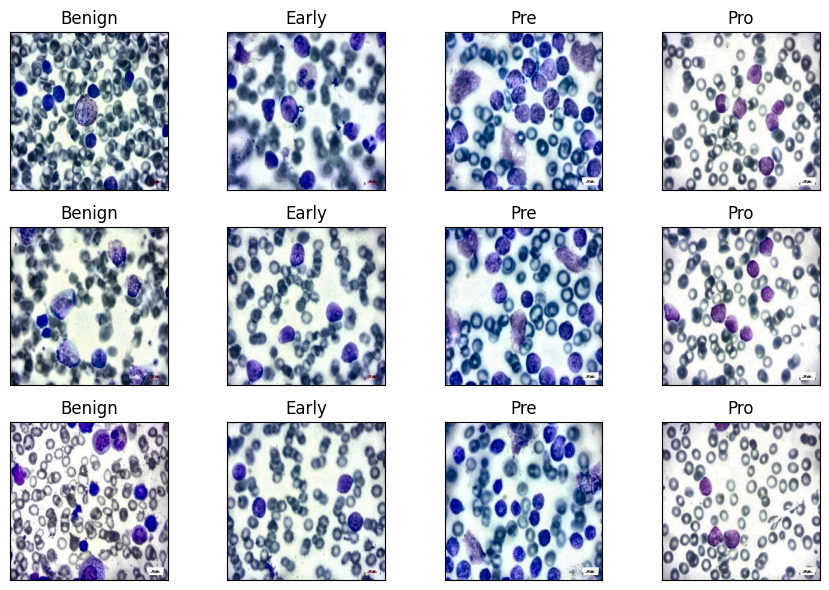

In [ ]:
show_sample_images(data=(X_train, y_train), n_images=3)

## Distribusi data masing-masing kelas

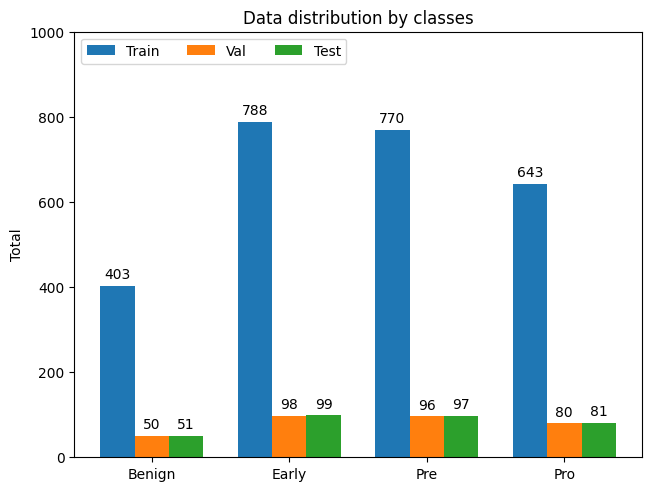

In [ ]:
plot_distribution_data(y_train, y_val, y_test)

## Membuat model

In [ ]:
model = Googlenet()

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='clahe_imbalance.weights.h5',
    monitor='val_result_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True,
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(
    X_train, [y_train, y_train, y_train],
    validation_data=(X_val, [y_val, y_val, y_val]),
    batch_size=32,
    epochs=40,
    callbacks=[cp_callback]
)

Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - aux_1_accuracy: 0.3810 - aux_1_loss: 1.2432 - aux_2_accuracy: 0.3516 - aux_2_loss: 0.3825 - loss: 2.0138 - result_accuracy: 0.3297 - result_loss: 0.3881
Epoch 1: val_result_accuracy improved from -inf to 0.54630, saving model to clahe_imbalance.weights.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 66s 399ms/step - aux_1_accuracy: 0.3830 - aux_1_loss: 1.2401 - aux_2_accuracy: 0.3533 - aux_2_loss: 0.3817 - loss: 2.0091 - result_accuracy: 0.3313 - result_loss: 0.3873 - val_aux_1_accuracy: 0.5278 - val_aux_1_loss: 0.8976 - val_aux_2_accuracy: 0.5679 - val_aux_2_loss: 0.2613 - val_loss: 1.5459 - val_result_accuracy: 0.5463 - val_result_loss: 0.2749
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - aux_1_accuracy: 0.7304 - aux_1_loss: 0.6091 - aux_2_accuracy: 0.7393 - aux_2_loss: 0.1845 - loss: 0.9904 - result_accuracy: 0.7248 - result_loss: 0.1967
Epoch 2: val_result_accuracy improved from 0.54630 to 0.81173, saving model to clahe_imbalance.weights.

## plot history accuracy dan loss

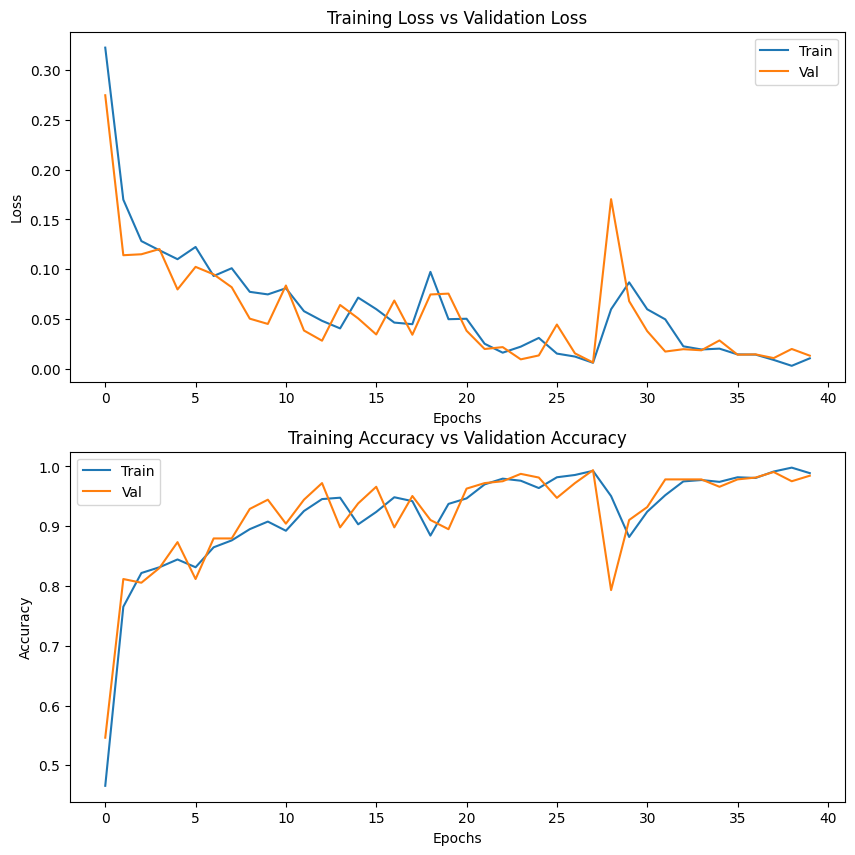

In [ ]:
plot_history(
    history.history['result_loss'],
    history.history['val_result_loss'],
    history.history['result_accuracy'],
    history.history['val_result_accuracy']
)

## Evaluasi model

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step


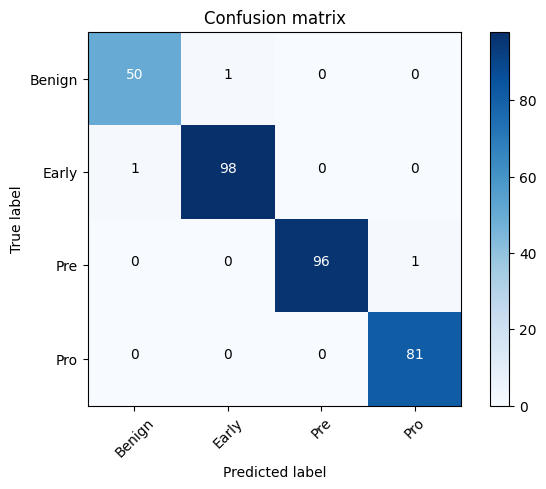

In [ ]:
# predict data test
model.load_weights('clahe_imbalance.weights.h5')
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
print(classification_report(y_test, y_pred.numpy(), target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Benign       0.98      0.94      0.96        51
       Early       0.99      0.98      0.98        99
         Pre       0.97      0.99      0.98        97
         Pro       0.99      1.00      0.99        81

    accuracy                           0.98       328
   macro avg       0.98      0.98      0.98       328
weighted avg       0.98      0.98      0.98       328



In [ ]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet", exist_ok=True)
tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/googlenet/clahe_imbalanced_model")

# Skenario 4 : data clahe dengan oversampling Deep SMOTE

## Membaca data

In [10]:
X_generated, y_generated = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/generated")

X_generated = X_generated / 255

# menggabungkan dengand data train asli
X_train = tf.concat([X_train, X_generated], axis=0)
y_train = tf.concat([y_train, y_generated], axis=0)

data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle dataset
shuffled_data = data.shuffle(buffer_size=len(X_train))
X_train, y_train = zip(*shuffled_data)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.uint8)

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/generated


100%|██████████| 385/385 [00:06<00:00, 61.55it/s] 
0it [00:00, ?it/s]
100%|██████████| 145/145 [00:02<00:00, 51.22it/s] 


## Sampel data

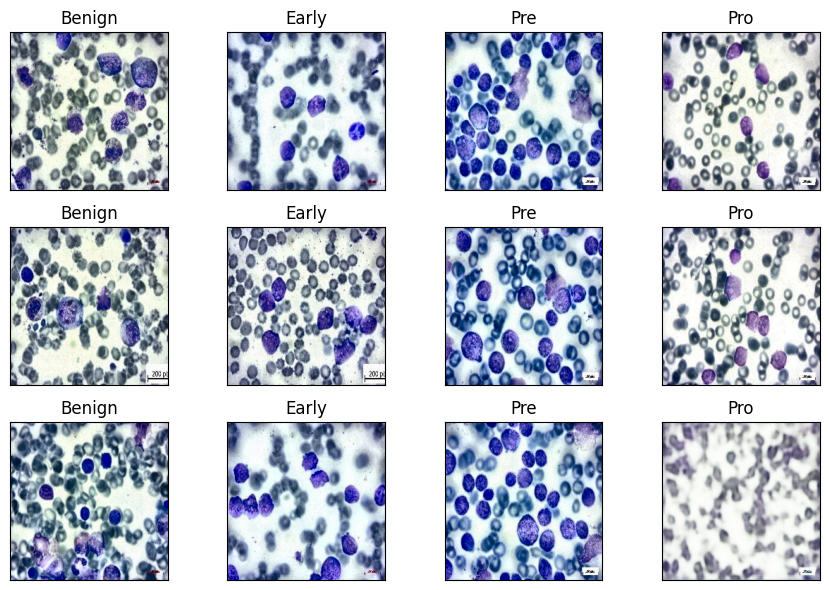

In [11]:
show_sample_images(data=(X_train, y_train), n_images=3)

## Distribusi data masing-masing kelas

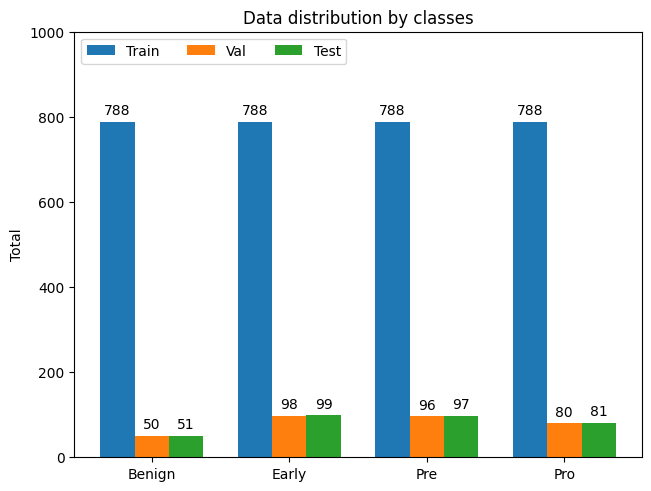

In [12]:
plot_distribution_data(y_train, y_val, y_test)

## Membuat model

In [13]:
model = Googlenet()

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='clahe_balance.weights.h5',
    monitor='val_result_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True,
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(
    X_train, [y_train, y_train, y_train],
    validation_data=(X_val, [y_val, y_val, y_val]),
    batch_size=32,
    epochs=40,
    callbacks=[cp_callback]
)

Epoch 1/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - aux_1_accuracy: 0.3552 - aux_1_loss: 1.2662 - aux_2_accuracy: 0.3239 - aux_2_loss: 0.3929 - loss: 2.0555 - result_accuracy: 0.3213 - result_loss: 0.3964
Epoch 1: val_result_accuracy improved from -inf to 0.71914, saving model to clahe_balance.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - aux_1_accuracy: 0.3568 - aux_1_loss: 1.2638 - aux_2_accuracy: 0.3253 - aux_2_loss: 0.3923 - loss: 2.0521 - result_accuracy: 0.3226 - result_loss: 0.3959 - val_aux_1_accuracy: 0.6574 - val_aux_1_loss: 0.5926 - val_aux_2_accuracy: 0.6173 - val_aux_2_loss: 0.1967 - val_loss: 1.0165 - val_result_accuracy: 0.7191 - val_result_loss: 0.1840
Epoch 2/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - aux_1_accuracy: 0.7380 - aux_1_loss: 0.6156 - aux_2_accuracy: 0.7215 - aux_2_loss: 0.1865 - loss: 0.9900 - result_accuracy: 0.7282 - result_loss: 0.1879
Epoch 2: val_result_accuracy improved from 0.71914 to 0.82407, saving model to clahe_balance.weights.h5
9

## plot history accuracy dan loss

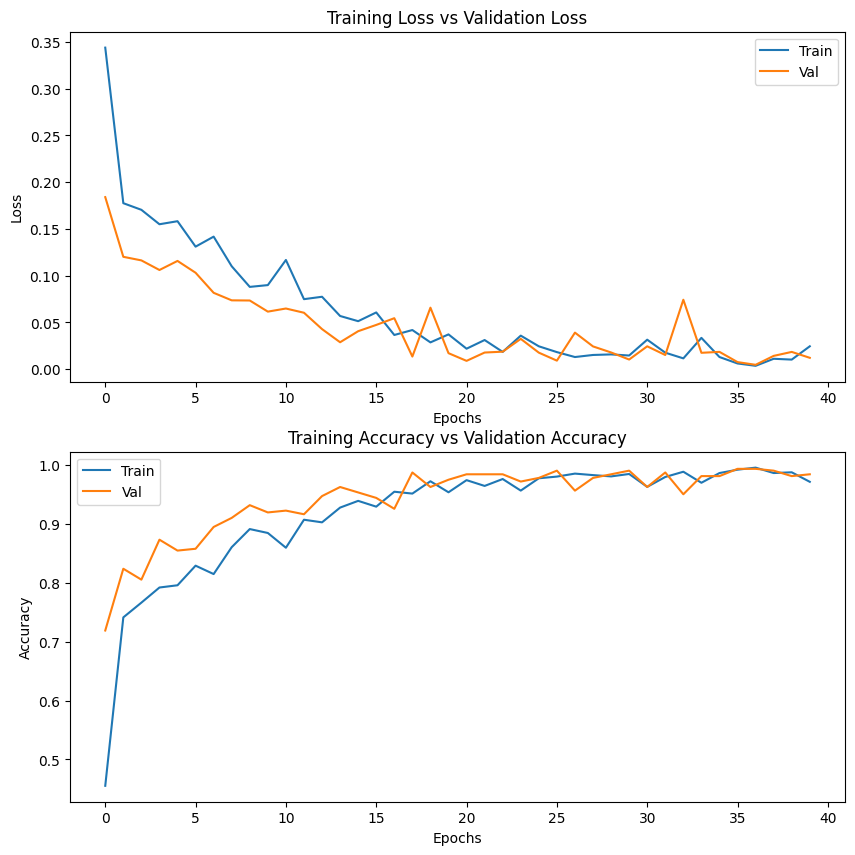

In [14]:
plot_history(
    history.history['result_loss'],
    history.history['val_result_loss'],
    history.history['result_accuracy'],
    history.history['val_result_accuracy']
)

## Evaluasi model

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 499ms/step


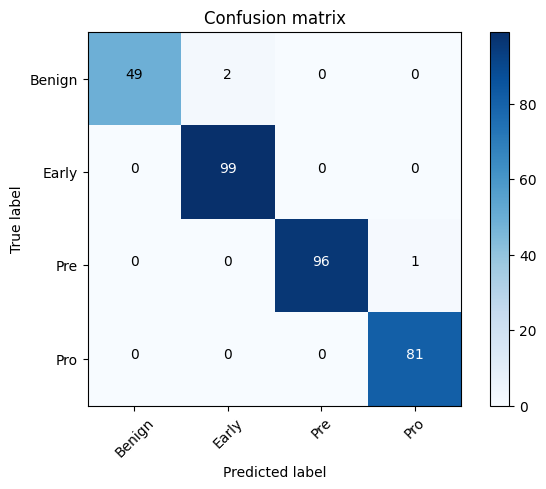

In [15]:
# predict data test
model.load_weights('clahe_balance.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred['result'], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [16]:
print(classification_report(y_test, y_pred.numpy(), target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98        51
       Early       0.98      1.00      0.99        99
         Pre       1.00      0.99      0.99        97
         Pro       0.99      1.00      0.99        81

    accuracy                           0.99       328
   macro avg       0.99      0.99      0.99       328
weighted avg       0.99      0.99      0.99       328



In [17]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet", exist_ok=True)
tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/googlenet/clahe_balanced_model")